In [1]:
from google.colab import drive
user_name = '/content/drive'
drive.mount(user_name, force_remount=True)
import os
os.environ['OMP_NUM_THREADS'] = '1'
import numpy as np
import time
import datetime
!pip install tensorboardX
!pip3 install box2d-py==2.3.8
!pip install gym==0.15.4 
import tensorboardX
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.multiprocessing as mp
from torch import optim
import pickle as pkl

import scipy.stats as ss
from tensorboardX import SummaryWriter
import gym
checkpoint_name = '/content/drive/My Drive/Colab Notebooks/Checkpoint/'
os.sched_setaffinity(os.getpid(), {0})
os.system("taskset -p 0xffffffff %d" % os.getpid())



Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 204kB 4.9MB/s 
     |████████████████████████████████| 450kB 4.5MB/s 
     |████████████████████████████████| 1.6MB 4.6MB/s 
     |████████████████████████████████| 1.0MB 42.9MB/s 
  Created wheel for gym: filename=gym-0.15.4-cp36-none-any.whl size=1648483 sha256=4c66c6cabceb5596a33d9c6f9558d6ed2d3aec5bf9a7a5e77604cffcdff2cf0a
  Stored in directory: /root/.cache/pip/wheels/e9/26/9b/8a1a6599a91077a938ac4348cc3d3ac84bfab0d

0

In [0]:
class NeuralNetwork(nn.Module):
    '''
    Neural network for continuous action space
    '''
    def __init__(self, input_shape, n_actions):
        super(NeuralNetwork, self).__init__()

        self.mlp = nn.Sequential(
            nn.Linear(input_shape, 32),
            nn.Tanh(),
            nn.Linear(32, 32),
            nn.Tanh())

        self.mean_l = nn.Linear(32, n_actions)
        self.mean_l.weight.data.mul_(0.1)

        self.var_l = nn.Linear(32, n_actions)
        self.var_l.weight.data.mul_(0.1)

        self.logstd = nn.Parameter(torch.zeros(n_actions))

    def forward(self, x):
        ot_n = self.mlp(x.float())
        return torch.tanh(self.mean_l(ot_n))



In [0]:
def sample_noise(neural_net):
    '''
    Sample noise for each parameter of the neural net
    '''
    nn_noise = []
    for n in neural_net.parameters():
        noise = np.random.normal(size=n.data.numpy().shape)
        nn_noise.append(noise)
    return np.array(nn_noise)

def evaluate_neuralnet(nn, env):
    '''
    Evaluate an agent running it in the environment and computing the total reward
    '''
    obs = env.reset()
    game_reward = 0

    while True:
        # Output of the neural net
        net_output = nn(torch.tensor(obs))
        # the action is the value clipped returned by the nn
        action = net_output.data.cpu().numpy().argmax()
        # action = np.clip(net_output.data.cpu().numpy().squeeze(), -1, 1)
        new_obs, reward, done, _ = env.step(action)
        obs = new_obs

        game_reward += reward

        if done:
            break

    return game_reward

def evaluate_noisy_net(noise, neural_net, env):
    '''
    Evaluate a noisy agent by adding the noise to the plain agent
    '''
    old_dict = neural_net.state_dict()

    # add the noise to each parameter of the NN
    for n, p in zip(noise, neural_net.parameters()):
        p.data += torch.FloatTensor(n * STD_NOISE)

    # evaluate the agent with the noise
    reward = evaluate_neuralnet(neural_net, env)
    # load the previous paramater (the ones without the noise)
    neural_net.load_state_dict(old_dict)

    return reward

def worker(params_queue, output_queue):
    '''
    Function execute by each worker: get the agent' NN, sample noise and evaluate the agent adding the noise. Then return the seed and the rewards to the central unit
    '''

    env = gym.make(ENV_NAME)
    actor = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)

    while True:
        # get the new actor's params
        act_params = params_queue.get()
        if act_params != None:
            # load the actor params
            actor.load_state_dict(act_params)

            # get a random seed
            seed = np.random.randint(1e6)
            # set the new seed
            np.random.seed(seed)

            noise = sample_noise(actor)

            pos_rew = evaluate_noisy_net(noise, actor, env)
            # Mirrored sampling
            neg_rew = evaluate_noisy_net(-noise, actor, env)

            output_queue.put([[pos_rew, neg_rew], seed])
        else:
            break


def normalized_rank(rewards):
    '''
    Rank the rewards and normalize them.
    '''
    ranked = ss.rankdata(rewards)
    norm = (ranked - 1) / (len(ranked) - 1)
    norm -= 0.5
    return norm


In [0]:
rolling_rewards = []
max_rewards = []
min_rewards = []
avg_rewards = []
time_list = []
elite_learners = []

ENV_NAME = 'Seaquest-ram-v0' #'BipedalWalker-v2'

# Hyperparameters
STD_NOISE = 1
BATCH_SIZE = 100
LEARNING_RATE = 0.1
MAX_ITERATIONS = 5000

MAX_WORKERS = 4

save_video_test = False
VIDEOS_INTERVAL = 100

now = datetime.datetime.now()
date_time = "{}_{}.{}.{}".format(now.day, now.hour, now.minute, now.second)

if __name__ == '__main__':
    # Writer name
    writer_name = 'ASY_ES_{}_{}_{}_{}_{}_{}'.format(ENV_NAME, date_time, str(STD_NOISE), str(BATCH_SIZE), str(LEARNING_RATE), str(MAX_ITERATIONS), str(MAX_WORKERS))
    print('Name:', writer_name)

    # Create the test environment
    env = gym.make(ENV_NAME)
    if save_video_test:
        env = gym.wrappers.Monitor(env,  "VIDEOS/TEST_VIDEOS_"+writer_name, video_callable=lambda episode_id: True)

    # Initialize the agent
    actor = NeuralNetwork(env.observation_space.shape[0], env.action_space.n)
    # Initialize the optimizer
    optimizer = optim.Adam(actor.parameters(), lr=LEARNING_RATE)

    writer = SummaryWriter(log_dir='content/runs/'+writer_name)

    # Queues to pass and get the variables to and from each processe
    output_queue = mp.Queue(maxsize=BATCH_SIZE)
    params_queue = mp.Queue(maxsize=BATCH_SIZE)

    processes = []

    # Create and start the processes
    for _ in range(MAX_WORKERS):
        p = mp.Process(target=worker, args=(params_queue, output_queue))
        p.start()
        processes.append(p)


    # Execute the main loop MAX_ITERATIONS times
    for n_iter in range(MAX_ITERATIONS):
        it_time = time.time()

        batch_noise = []
        batch_reward = []

        # create the queue with the actor parameters
        for _ in range(BATCH_SIZE):
            params_queue.put(actor.state_dict())

        # receive from each worker the results (the seed and the rewards)
        for i in range(BATCH_SIZE):
            p_rews, p_seed = output_queue.get()

            np.random.seed(p_seed)
            noise = sample_noise(actor)
            batch_noise.append(noise)
            batch_noise.append(-noise)

            batch_reward.append(p_rews[0]) # reward of the positive noise
            batch_reward.append(p_rews[1]) # reward of the negative noise

        # Print some stats
        avg_reward = np.round(np.mean(batch_reward), 2)
        print(n_iter, 'Mean:',avg_reward, 'Max:', np.round(np.max(batch_reward), 2), 'Time:', np.round(time.time()-it_time, 2))
        writer.add_scalar('reward', np.mean(batch_reward), n_iter)
        if len(avg_rewards)>10:
          rolling_rewards.append(np.mean(avg_rewards[-10:]))
        max_rewards.append(np.max(batch_reward))
        min_rewards.append(np.min(batch_reward))
        avg_rewards.append(avg_reward)
        time_list.append(time.time()-it_time)
        count = 0
        for k in batch_reward:
          if k > avg_reward:
            count += 1
        elite_learners.append(count)
            
        # Rank the reward and normalize it
        batch_reward = normalized_rank(batch_reward)


        th_update = []
        optimizer.zero_grad()
        # for each actor's parameter, and for each noise in the batch, update it by the reward * the noise value
        for idx, p in enumerate(actor.parameters()):
            upd_weights = np.zeros(p.data.shape)

            for n,r in zip(batch_noise, batch_reward):
                upd_weights += r*n[idx]

            upd_weights = upd_weights / (BATCH_SIZE*STD_NOISE)
            # put the updated weight on the gradient variable so that afterwards the optimizer will use it
            p.grad = torch.FloatTensor( -upd_weights)
            th_update.append(np.mean(upd_weights))

        # Optimize the actor's NN
        optimizer.step()

        writer.add_scalar('loss', np.mean(th_update), n_iter)

        if n_iter % VIDEOS_INTERVAL == 0:
            print('Test reward:',evaluate_neuralnet(actor, env))
            torch.save({'model_state_dict': actor.state_dict(), 'optimizer_state_dict': optimizer.state_dict()},
                       checkpoint_name+'/actor.pth.tar')

    # quit the processes
    for _ in range(MAX_WORKERS):
        params_queue.put(None)

    for p in processes:
        p.join()

    data_save = {}
    data_save['elite_learners'] = elite_learners
    data_save['time'] = time_list
    data_save['rolling_rewards'] = rolling_rewards
    data_save['max_rewards'] = max_rewards
    data_save['min_reward'] = min_rewards
    data_save['avg_reward'] = avg_rewards

    with open(checkpoint_name+'data.pkl', 'wb') as f:
        pkl.dump(data_save, f)

    


Name: ASY_ES_Seaquest-ram-v0_20_0.42.48_1_100_0.1_5000
0 Mean: 27.3 Max: 260.0 Time: 807.96
Test reward: 20.0
1 Mean: 43.4 Max: 360.0 Time: 566.37
2 Mean: 64.0 Max: 360.0 Time: 220.89
3 Mean: 83.5 Max: 360.0 Time: 201.33
4 Mean: 103.7 Max: 340.0 Time: 175.17
5 Mean: 129.3 Max: 420.0 Time: 160.0
6 Mean: 154.9 Max: 440.0 Time: 178.16
7 Mean: 101.9 Max: 340.0 Time: 184.2
8 Mean: 123.6 Max: 420.0 Time: 162.5
9 Mean: 117.2 Max: 400.0 Time: 167.28
10 Mean: 125.7 Max: 380.0 Time: 179.65
11 Mean: 150.0 Max: 460.0 Time: 200.45
12 Mean: 145.7 Max: 420.0 Time: 193.97
13 Mean: 126.3 Max: 420.0 Time: 195.25
14 Mean: 93.1 Max: 480.0 Time: 193.22
15 Mean: 86.2 Max: 460.0 Time: 172.46
16 Mean: 77.6 Max: 320.0 Time: 175.08
17 Mean: 72.3 Max: 320.0 Time: 161.0
18 Mean: 81.4 Max: 460.0 Time: 172.37
19 Mean: 77.1 Max: 300.0 Time: 161.86
20 Mean: 75.7 Max: 400.0 Time: 165.81
21 Mean: 78.4 Max: 340.0 Time: 183.48
22 Mean: 74.2 Max: 320.0 Time: 169.33
23 Mean: 74.3 Max: 280.0 Time: 169.87
24 Mean: 80.2 Max: 

Process Process-4:
Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
Process Process-1:
Process Process-3:
  File "<ipython-input-3-b3f65c78d858>", line 75, in worker
    neg_rew = evaluate_noisy_net(-noise, actor, env)
Traceback (most recent call last):
  File "<ipython-input-3-b3f65c78d858>", line 45, in evaluate_noisy_net
    reward = evaluate_neuralnet(neural_net, env)
Traceback (most recent call last):
Process Process-2:
  File "/usr/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "<ipython-input-3-b3f65c78d858>", line 20, in evaluate_neuralnet
    net_output = nn(torch.tensor(obs))
  File "/usr/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/usr/lib/python3.6/multiprocessing/proce

KeyboardInterrupt: ignored

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('dark', {'axes.grid' : True})

plt.figure(figsize=(20,6))

plt.subplot(141)
plt.title('Episodic Reward')
plt.plot(np.arange(0,len(avg_rewards),1),avg_rewards, color='royalblue')
plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)


plt.subplot(142)
plt.title('Rolling Average Reward')
plt.plot(rolling_rewards)

plt.subplot(143)
plt.title('Time Per Episode')
plt.plot(time_list)

plt.subplot(144)
plt.title('Elite Learners')
plt.plot(elite_learners)


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


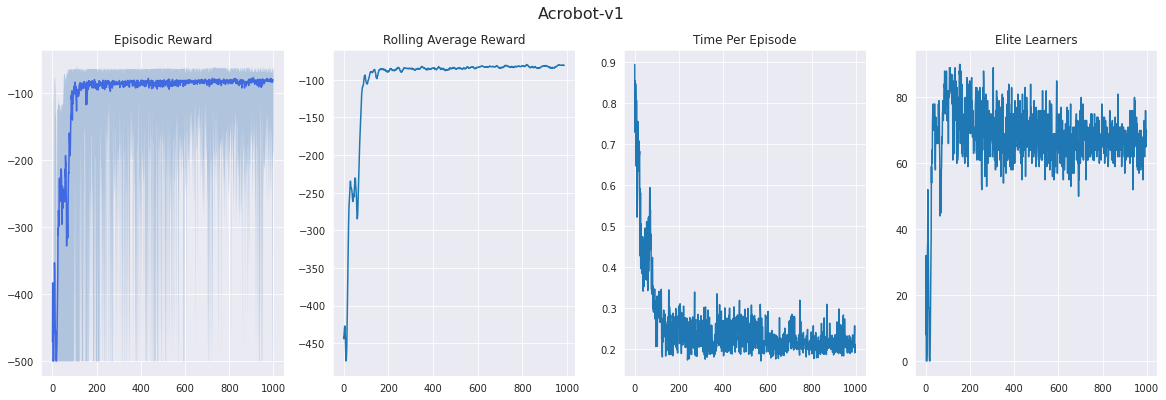

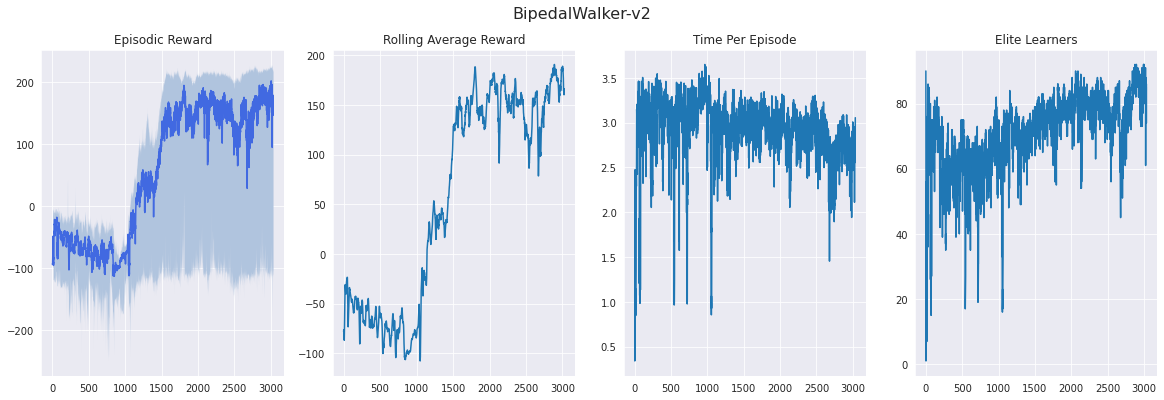

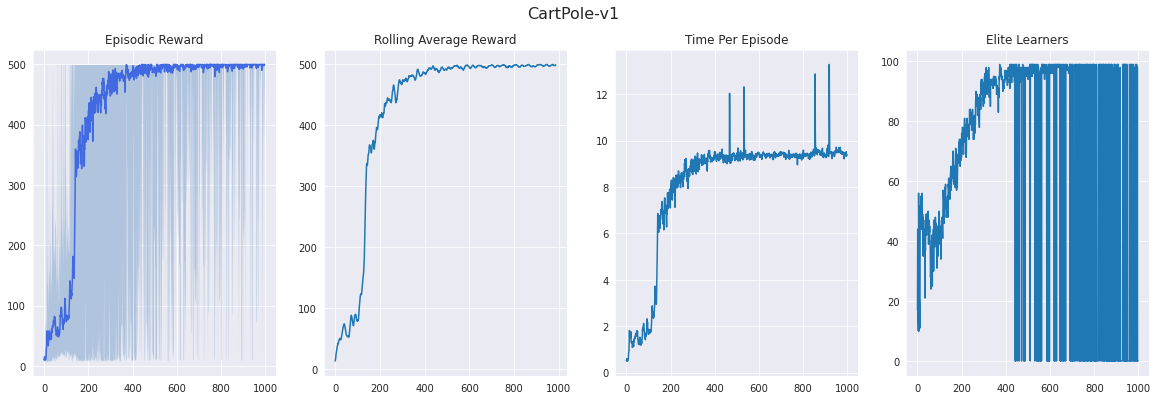

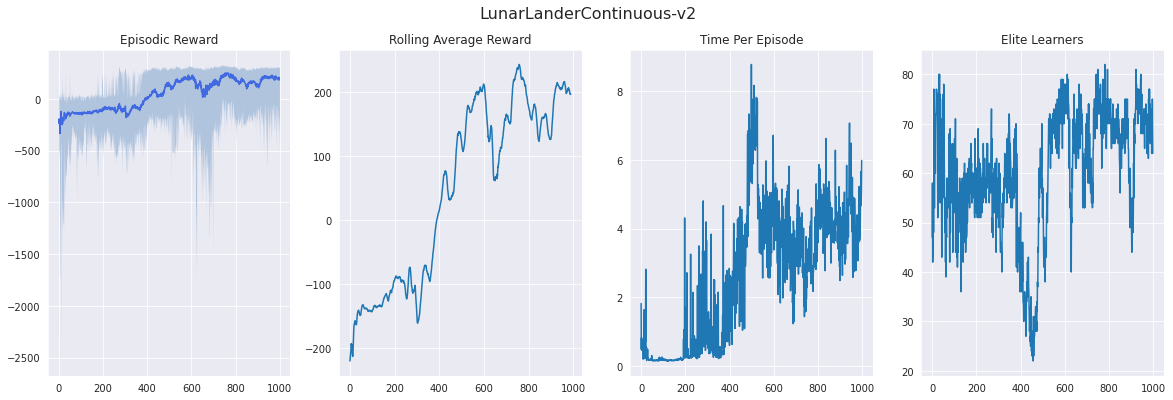

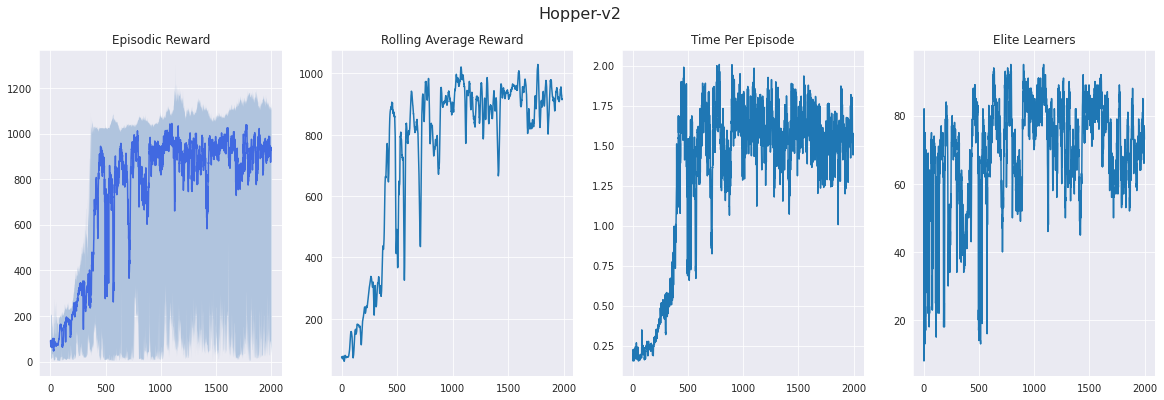

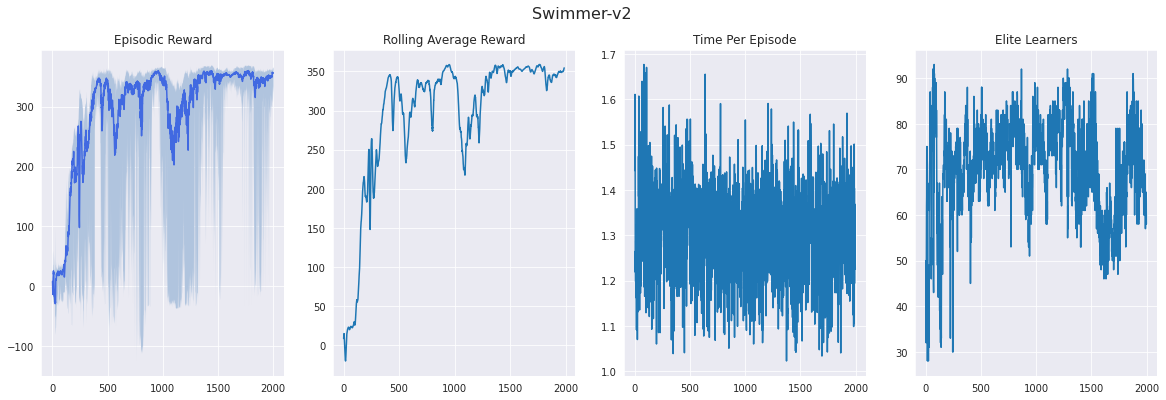

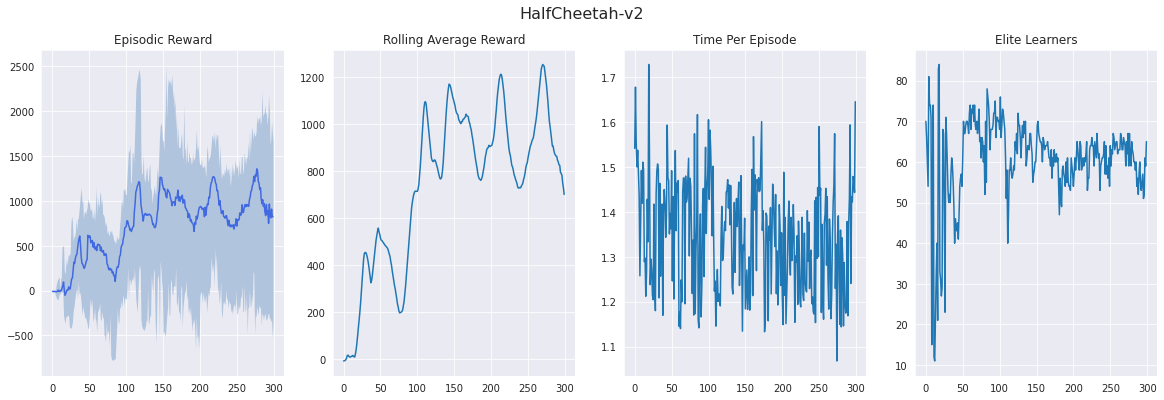

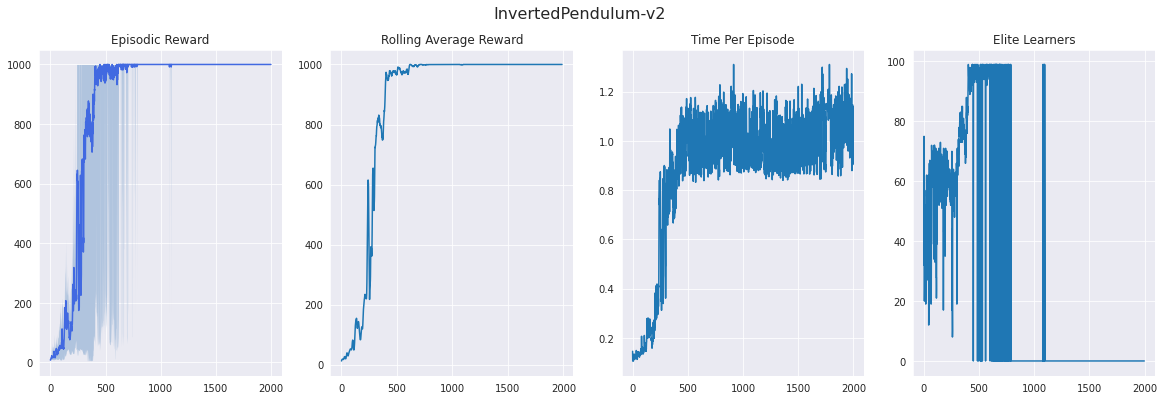

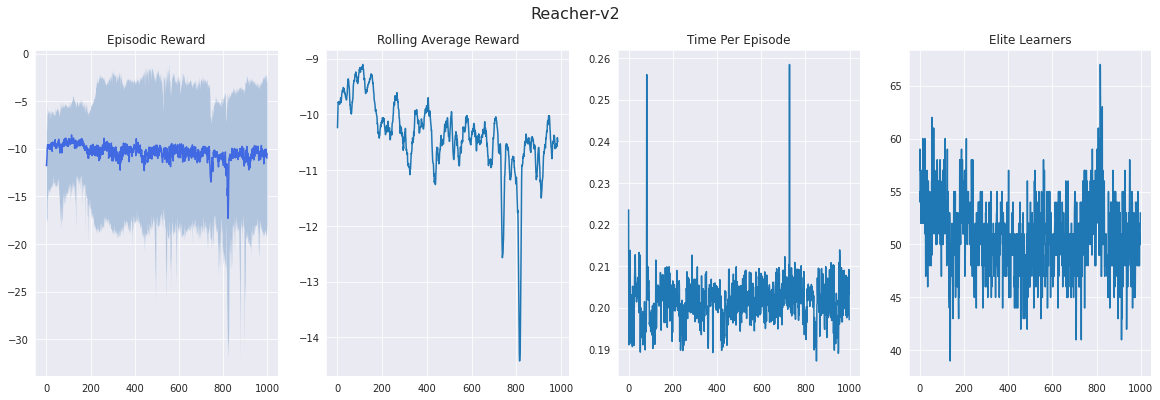

In [2]:
env_list = ['Acrobot-v1','BipedalWalker-v2','CartPole-v1','LunarLanderContinuous-v2','Hopper-v2','Swimmer-v2','HalfCheetah-v2',
            'InvertedPendulum-v2','Reacher-v2']
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style('dark', {'axes.grid' : True})

for j in env_list:
  check_name = checkpoint_name+j+'/data.pkl'
  data = pkl.load(open(check_name,'rb'))
  if j=='HalfCheetah-v2':
    x = 300
  else:
    x = -1
  avg_rewards = data['avg_reward'][:x]
  max_rewards = data['max_rewards'][:x]
  min_rewards = data['min_reward'][:x]
  rolling_rewards = data['rolling_rewards'][:x]
  time_list = data['time'][:x]
  elite_learners = data['elite_learners'][:x]

  plt.figure(figsize=(20,6))
  plt.suptitle(j,fontsize='16')

  plt.subplot(141)
  plt.title('Episodic Reward')
  plt.plot(np.arange(0,len(avg_rewards),1),avg_rewards, color='royalblue')
  plt.fill_between(np.arange(0,len(avg_rewards),1),min_rewards,max_rewards,facecolor='lightsteelblue',linewidth=0)

  plt.subplot(142)
  plt.title('Rolling Average Reward')
  plt.plot(rolling_rewards)

  plt.subplot(143)
  plt.title('Time Per Episode')
  plt.plot(time_list)

  plt.subplot(144)
  plt.title('Elite Learners')
  plt.plot(elite_learners)
